<a href="https://colab.research.google.com/github/pippahtlin/Extreme-Precipitation/blob/main/orisoi_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

In [51]:
df = pd.read_csv("https://raw.githubusercontent.com/pippahtlin/Extreme-Precipitation/main/data/precipitation_originsoi",index_col = "date")
df.index = pd.to_datetime(df.index)
df

,year,month,day,daily rain,binary rain,soi
date,,,,,,
1899-10-11,1899,10,11,3.048000,0,-2.0
1899-10-12,1899,10,12,2.032000,0,-2.0
1899-10-13,1899,10,13,33.020000,1,-2.0
1899-10-14,1899,10,14,0.508000,0,-2.0
1899-10-15,1899,10,15,0.000000,0,-2.0
...,...,...,...,...,...,...
2022-12-27,2022,12,27,0.000000,0,2.6
2022-12-28,2022,12,28,22.859999,0,2.6
2022-12-29,2022,12,29,0.000000,0,2.6


#### MinMax Scaler:
Here we want to scale the `daily rain` column, and then creating the 7 lagged columns based in the scaled `daily rain`:
1. First determine the training part of the data, and only fit the scaler with training data to avoid data leakage
2. Create a new column `tf_daily rain` which transform the `daily rain` column using the scaler, so that the 7 `rain_lag_i` columns can be created.
3. After that, we can split the train, validation, and test data, and we only need to transform the `daily rain` part, which is the target.

In [52]:
scaler = MinMaxScaler()

# 1. Determine the training target set and fit the scaler
total_rows = len(df)
train_end = int(total_rows * 0.6) # 60%

train_rain = df.iloc[:train_end]['daily rain']
train_rain_2d = train_rain.values.reshape(-1, 1)

# Fit the scaler
sc = MinMaxScaler(feature_range=(0,80))
sc.fit(train_rain_2d)

MinMaxScaler(feature_range=(0, 80))

In [54]:
# 2. With the fitted scaler, create  the transformed daily rain column
df['tf_daily rain'] = sc.transform(df['daily rain'].values.reshape(-1, 1))

# Create lagged rainfall features for the previous 7 days
for lag in range(1, 8):  # for 1 to 7 days lag
    df[f'rain_lag_{lag}'] = df['tf_daily rain'].shift(lag)

# Drop rows where any of the lagged values are NaN, which will mostly be the initial rows
df.dropna(inplace=True)

df

,year,month,day,daily rain,binary rain,soi,tf_daily rain,rain_lag_1,rain_lag_2,rain_lag_3,rain_lag_4,rain_lag_5,rain_lag_6,rain_lag_7
date,,,,,,,,,,,,,,
1899-10-18,1899,10,18,0.000000,0,-2.0,0.000000,0.000000,0.000000,0.000000,0.230216,14.964029,0.920863,1.381295
1899-10-19,1899,10,19,0.000000,0,-2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.230216,14.964029,0.920863
1899-10-20,1899,10,20,0.000000,0,-2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230216,14.964029
1899-10-21,1899,10,21,11.684000,0,-2.0,5.294964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230216
1899-10-22,1899,10,22,0.000000,0,-2.0,0.000000,5.294964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,2022,12,27,0.000000,0,2.6,0.000000,0.000000,0.000000,0.115108,0.000000,0.000000,0.000000,0.000000
2022-12-28,2022,12,28,22.859999,0,2.6,10.359712,0.000000,0.000000,0.000000,0.115108,0.000000,0.000000,0.000000
2022-12-29,2022,12,29,0.000000,0,2.6,0.000000,10.359712,0.000000,0.000000,0.000000,0.115108,0.000000,0.000000


In [58]:
# 3. Split the data (train 60%, validation 20%, test 20% )
total_rows = len(df)
train_end = int(total_rows * 0.6) # same as 1
validation_end = train_end + int(total_rows * 0.2)

# Define the feature column
col_feature = ['soi']+[f'rain_lag_{i}' for i in range(1, 8)]

# Using iloc for integer-location based indexing
train_features = df[col_feature].iloc[:train_end]
train_rain = df.iloc[:train_end]['tf_daily rain']

validation_features = df[col_feature].iloc[train_end:validation_end]
validation_rain = df.iloc[train_end:validation_end]['tf_daily rain']

test_features = df[col_feature].iloc[validation_end:]
test_rain = df.iloc[validation_end:]['tf_daily rain']

In [60]:
T = 90 # Consider seasonality

# Prepend the last T-1 observations from the training set to the validation features
prepend_features_to_validation = train_features.iloc[-(T-1):]
validation_features = pd.concat([prepend_features_to_validation, validation_features], axis=0)

# Similarly, prepend the last T-1 observations from the validation set (including the part that was just prepended) to the test features
prepend_features_to_test = validation_features.iloc[-(T-1):]
test_features = pd.concat([prepend_features_to_test, test_features], axis=0)

# Output the shapes of the datasets to check everything is as expected
train_features.shape, train_rain.shape, validation_features.shape, validation_rain.shape, test_features.shape, test_rain.shape

((27000, 8), (27000,), (9178, 8), (9000,), (9178, 8), (9000,))

In [61]:
# Create sequences of T timesteps
X_train, y_train = [], []
for i in range(len(train_rain) - (T-1)):
    X_train.append(train_features.iloc[i:i+T].values)
    y_train.append(train_rain.iloc[i + (T-1)])

X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1) # Reshape to vector for model
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')


X_val, y_val = [], []
for i in range(len(validation_rain) - (T-1)):
    X_val.append(validation_features.iloc[i:i+T].values)
    y_val.append(validation_rain.iloc[i + (T-1)])
X_val, y_val = np.array(X_val), np.array(y_val).reshape(-1,1)
print(f'Validation data dimensions: {X_val.shape}, {y_val.shape}')

X_test, y_test = [], []
for i in range(len(test_rain)):
    X_test.append(test_features.iloc[i:i+T].values)
    y_test.append(test_rain.iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)
print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

Train data dimensions: (26911, 90, 8), (26911, 1)
Validation data dimensions: (8911, 90, 8), (8911, 1)
Test data dimensions: (9000, 90, 8), (9000, 1)


#### Build Model

In [62]:
# Import Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from keras import metrics

In [63]:
# 1. Make a list of CONSTANTS for modelling:
LAYERS = [50, 50, 1]                # number of units in hidden and output layers (possible tune)
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_VAL = X_val.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 30                           # number of epochs (possible tune)
LR = 0.05                            # learning rate of the gradient descent (possible tune)
LAMBD = 0.03                         # lambda in L2 regularizaion (possible tune)
DP = 0.2                             # dropout rate (possible tune)
RDP = 0.0                            # recurrent dropout rate (possible tune)
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

layers=[50, 50, 1], train_examples=26911, test_examples=9000
batch = 26911, timesteps = 90, features = 8, epochs = 30
lr = 0.05, lambda = 0.03, dropout = 0.2, recurr_dropout = 0.0


In [64]:
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True
              ))
model.add(LSTM(units=LAYERS[1],
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP
              ))
model.add(Dense(units=1))

In [65]:
# 3. Compile the model with Adam optimizer
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[metrics.MeanSquaredError(),metrics.AUC()])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss',
                             patience=2, verbose=0,
                             factor=0.001, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='loss', min_delta=0,
                           patience=2, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 90, 50)            11800     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32051 (125.20 KB)
Trainable params: 32051 (125.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [33]:
"""
# 4. Train the model.
# The dataset is small for NN - let's use test_data for validation -- should use cross-validation
start = time()
History = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    shuffle=True)
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
"""

Epoch 1/30
841/841 [==============================] - 71s 79ms/step - loss: 9.5984 - mean_squared_error: 8.8820 - auc_1: 0.7111 - val_loss: 12.2599 - val_mean_squared_error: 12.0522 - val_auc_1: 0.5184
Epoch 2/30
841/841 [==============================] - 68s 81ms/step - loss: 8.9070 - mean_squared_error: 8.7014 - auc_1: 0.7231 - val_loss: 12.3522 - val_mean_squared_error: 12.2176 - val_auc_1: 0.5146
Epoch 3/30
841/841 [==============================] - 66s 78ms/step - loss: 8.8792 - mean_squared_error: 8.7072 - auc_1: 0.7205 - val_loss: 12.2854 - val_mean_squared_error: 12.0760 - val_auc_1: 0.5343
Epoch 4/30
841/841 [==============================] - 66s 78ms/step - loss: 8.8531 - mean_squared_error: 8.6913 - auc_1: 0.7263 - val_loss: 12.8012 - val_mean_squared_error: 12.6684 - val_auc_1: 0.5019
Epoch 5/30
841/841 [==============================] - 66s 79ms/step - loss: 8.8299 - mean_squared_error: 8.6873 - auc_1: 0.7270 - val_loss: 12.3021 - val_mean_squared_error: 12.1778 - val_auc_

In [66]:
# 5. Evaluate the model:
train_eval = model.evaluate(X_train, y_train, batch_size=M_TRAIN, verbose=0)
val_eval = model.evaluate(X_val, y_val, batch_size=M_VAL, verbose=0)

print(f"Training:\nLoss: {train_eval[0]}，MSE: {train_eval[1]}, AUC: {train_eval[2]}")
print(f"Validation:\nLoss: {val_eval[0]}，MSE: {val_eval[1]}, AUC: {val_eval[2]}")

Training:
Loss: 15.5913667678833，MSE: 9.714424133300781, AUC: 0.45366862416267395
Validation:
Loss: 17.922401428222656，MSE: 12.045456886291504, AUC: 0.6032453179359436


In [35]:
model.evaluate(X_test, y_test, batch_size=M_TEST, verbose=0)

[7.727972984313965, 7.626265525817871, 0.7586824297904968]

In [36]:
model.save("orisoi_ver2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Summary
<br>

### Model 1:orisoi_ver1.h5
LAYERS = [50, 50, 1]                
EPOCH = 50                          
LR = 0.05                            
LAMBD = 0.03                         
DP = 0.2                             
RDP = 0.0    
<br>
- Training:Loss: 8.533666610717773，MSE: 8.46838092803955, AUC: 0.7586538791656494
- Validation:Loss: 12.47325611114502，MSE: 12.407970428466797, AUC: 0.4752662777900696
- [7.809525012969971, 7.744239807128906, 0.7541664242744446]

<br>



In [67]:
model1 = load_model('/content/orisoi_ver1.h5')

In [68]:
validation_predictions = model1.predict(X_val)
validation_predictions = sc.inverse_transform(validation_predictions)
validation_actual = sc.inverse_transform(y_val.reshape(-1,1))

# Create a dataset to compare
validation_compare = pd.DataFrame({'Actual': validation_actual.flatten(), 'Predicted': validation_predictions.flatten()})
validation_compare.head(20)

279/279 [==============================] - 9s 28ms/step


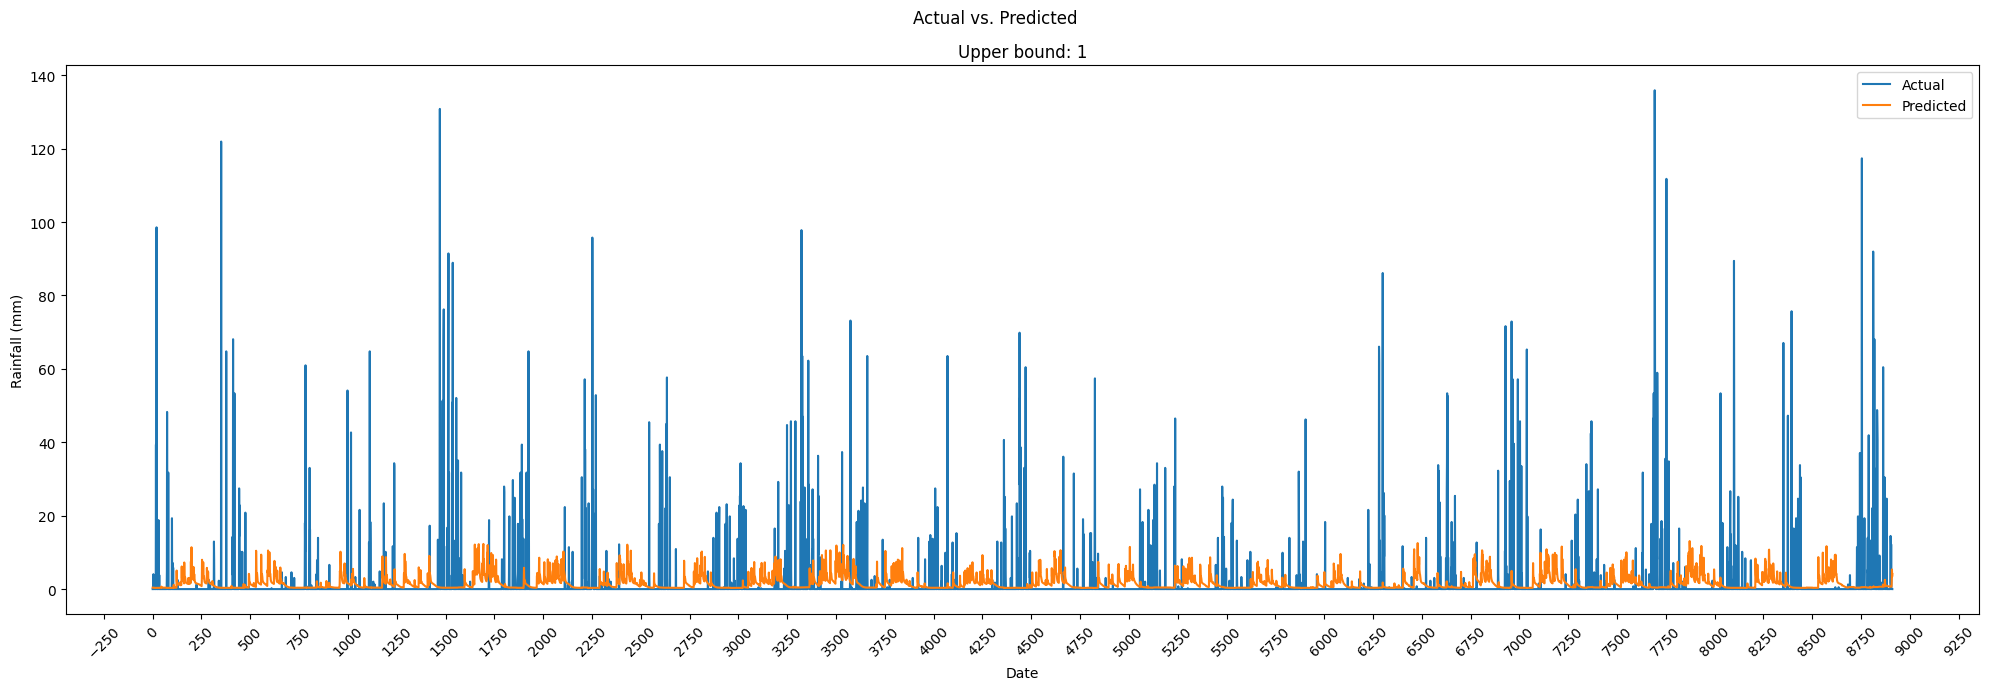

In [72]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(validation_compare['Actual'])
plt.plot(validation_compare['Predicted'])
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Model 1")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()

plt.savefig('compare_upper1.png')

plt.show()

### Model 2:orisoi_ver2.h5
LAYERS = [50, 50, 1]                
EPOCH = 30                          
LR = 0.05                            
LAMBD = 0.03                         
DP = 0.2                             
RDP = 0.0   
lr_decay = ReduceLROnPlateau(monitor='loss',
                             patience=2, verbose=0,
                             factor=0.001, min_lr=1e-8);
early_stop = EarlyStopping(monitor='loss', min_delta=0,
                           patience=2, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

<br>

- Training:
Loss: 8.495892524719238，MSE: 8.394185066223145, AUC: 0.7678706049919128
- Validation:
Loss: 12.705231666564941，MSE: 12.603524208068848, AUC: 0.49898356199264526
- [7.727972984313965, 7.626265525817871, 0.7586824297904968]

In [74]:
model2 = load_model('/content/orisoi_ver2.h5')

In [75]:
validation_predictions = model2.predict(X_val)
validation_predictions = sc.inverse_transform(validation_predictions)
validation_actual = sc.inverse_transform(y_val.reshape(-1,1))

# Create a dataset to compare
validation_compare = pd.DataFrame({'Actual': validation_actual.flatten(), 'Predicted': validation_predictions.flatten()})
validation_compare.head(20)

279/279 [==============================] - 9s 30ms/step


,Actual,Predicted
0,0.000,0.043137
1,0.000,0.028620
2,0.000,0.013090
3,0.000,0.002651
4,4.064,-0.003897
5,0.000,-0.008005
6,0.000,-0.010644
7,0.000,-0.012403
8,0.000,-0.060758
9,0.254,-0.047381


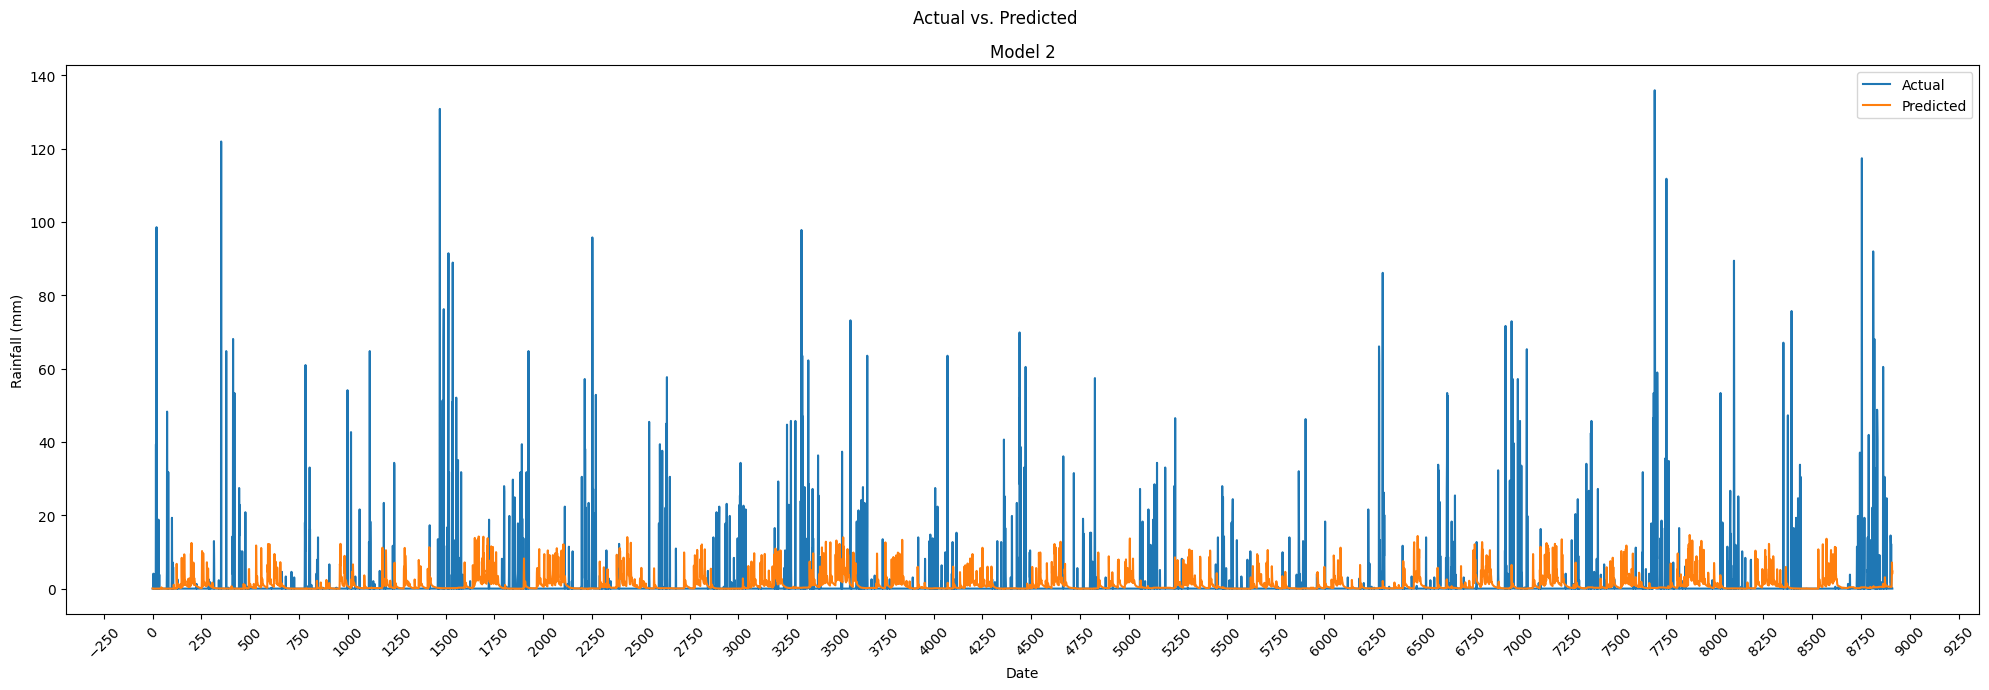

In [76]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(validation_compare['Actual'])
plt.plot(validation_compare['Predicted'])
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Model 2")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()

plt.savefig('compare_upper1.png')

plt.show()

As we observe a systematic lag on the prediction and the observation, we may consider it is the problem of using the lagged 7 days as features, which have the prediction highly dependent on the predictions of previous days.